In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip - ‘glove.6B.zip’ saved [862182613/862182613]

In [4]:
!unzip glove.6B.zip

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import joblib
import datetime
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('df_preprocessed.csv')
print(df.shape)
df.head()

(20800, 8)


,title,author,text,label,title_len,text_len,concat_title_text,concat_title_author
0,house dem aide even see comey letter jason cha...,darrell lucus,house dem aide even see comey letter jason cha...,1,10,444,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...
1,flynn hillary clinton big woman campus breitbart,daniel j flynn,ever get feeling life circle roundabout rather...,0,7,381,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...
2,truth might get fired,consortiumnews com,truth might get fired october 29 2016 tension ...,1,4,710,truth might get fired truth might get fired oc...,truth might get fired consortiumnews com
3,15 civilian killed single u airstrike identified,jessica purkiss,video 15 civilian killed single u airstrike id...,1,7,321,15 civilian killed single u airstrike identifi...,15 civilian killed single u airstrike identifi...
4,iranian woman jailed fictional unpublished sto...,howard portnoy,print iranian woman sentenced six year prison ...,1,10,89,iranian woman jailed fictional unpublished sto...,iranian woman jailed fictional unpublished sto...


In [7]:
df.title.fillna(' ', inplace=True)
df.text.fillna(' ', inplace=True)
df.author.fillna(' ', inplace=True)

In [8]:
df[df.isnull().any(1)].shape

(0, 8)

In [9]:
X, y = df.drop('label', axis=1), df.label
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.08, random_state=23)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19136, 7), (1664, 7), (19136,), (1664,))

<br><br><br>

# Vectorization

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from sklearn.metrics import confusion_matrix

In [12]:
title_len_scaler = MinMaxScaler()
x_train['title_len'] = title_len_scaler.fit_transform(x_train['title_len'].values.reshape(-1,1))
x_test['title_len']  = title_len_scaler.transform(x_test['title_len'].values.reshape(-1,1))
joblib.dump(title_len_scaler, 'fake_news/title_len_min_max_scaler')

['fake_news/title_len_min_max_scaler']

In [13]:
text_len_scaler = MinMaxScaler()
x_train['text_len'] = text_len_scaler.fit_transform(x_train['text_len'].values.reshape(-1,1))
x_test['text_len']  = text_len_scaler.transform(x_test['text_len'].values.reshape(-1,1))
joblib.dump(text_len_scaler, 'fake_news/text_len_min_max_scaler')

['fake_news/text_len_min_max_scaler']

In [14]:
def one_hot_encoder(train_, test_, title_name):
  vect_ = CountVectorizer(max_features=100000,ngram_range=(1, 3))
  train_vect = vect_.fit_transform(train_)
  test_vect =vect_.transform(test_)
  joblib.dump(vect_, f'fake_news/one_hot_encoder_{title_name}')
  return train_vect, test_vect

In [15]:
def tfidf_encoder(train_, test_, title_name):
  vect_ = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
  train_vect = vect_.fit_transform(train_)
  test_vect  = vect_.transform(test_)
  joblib.dump(vect_, f'fake_news/tfidf_encoder_{title_name}')
  return train_vect, test_vect

In [16]:
# converting to one hot encoder values
x_train_text_one_hot, x_test_text_one_hot = one_hot_encoder(x_train.concat_title_text.values, x_test.concat_title_text.values, 'title_text')
x_train_author_one_hot, x_test_author_one_hot = one_hot_encoder(x_train.concat_title_author.values, x_test.concat_title_author.values, 'title_author')


In [17]:
# converting to tfidf values
x_train_text_tfidf, x_test_text_tfidf = tfidf_encoder(x_train.concat_title_text.values, x_test.concat_title_text.values, 'title_text')
x_train_author_tfidf, x_test_author_tfidf = tfidf_encoder(x_train.concat_title_author.values, x_test.concat_title_author.values, 'title_author')

In [18]:
x_train_text_one_hot, x_test_text_one_hot

(<19136x100000 sparse matrix of type '<class 'numpy.int64'>'
 	with 6986008 stored elements in Compressed Sparse Row format>,
 <1664x100000 sparse matrix of type '<class 'numpy.int64'>'
 	with 599233 stored elements in Compressed Sparse Row format>)

In [19]:
x_train.title_len.values.reshape(-1,1).shape

(19136, 1)

In [20]:
# stacking the features horizontally
X_train_hstack_one_hot = sparse.hstack((x_train_text_one_hot, x_train_author_one_hot, \
                                x_train.title_len.values.reshape(-1,1), x_train.text_len.values.reshape(-1,1))).tocsr()
x_test_hstack_one_hot = sparse.hstack((x_test_text_one_hot, x_test_author_one_hot, \
                                x_test.title_len.values.reshape(-1,1), x_test.text_len.values.reshape(-1,1))).tocsr()

In [21]:
# stacking the features horizontally
X_train_hstack_tfidf = sparse.hstack((x_train_text_tfidf, x_train_author_tfidf, \
                                x_train.title_len.values.reshape(-1,1), x_train.text_len.values.reshape(-1,1))).tocsr()
x_test_hstack_tfidf = sparse.hstack((x_test_text_tfidf, x_test_author_tfidf, \
                                x_test.title_len.values.reshape(-1,1), x_test.text_len.values.reshape(-1,1))).tocsr()

<br><br><br>

# Models

In [22]:
import itertools
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score

In [23]:
def hyperparameter_tuning(x, y, model, params, cv, model_name):
    '''
        The function is used for finding out the hyperparameters using RandomSearchCV.
        input: data_points(x,y) to which the model has to fit, 
                model: linear_model for which the parameters are to be found,
                params: parameters ,
                cv: cross validation which is of int type,
                model_name: model name of string type 

        returns: best_hyperparameters
    '''
    start_time = datetime.datetime.now()
    clf = GridSearchCV(estimator = model, param_grid = params,n_jobs=-1, cv=cv, return_train_score=True, verbose=10)
    clf.fit(x,y)
    print('Calculating the parameters for {} model'.format(model_name))
    print()
    print('-'*40)
    print('best hyperparameters are:-',clf.best_params_)
    
    print()
    print('time taken - ',datetime.datetime.now() - start_time)

    return clf

In [24]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def model_training(clf, X_train, y_train, X_test, y_test):
  print('------------------------fitting the data to classifier------------------------')
  clf.fit(X_train, y_train)
  print('------------------------predicting the test data------------------------')
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print('------------------------plotting the confusion matrix------------------------')
  cm1 = confusion_matrix(y_test, y_pred.reshape(-1,1))
  plot_confusion_matrix(cm1, classes=['fake', 'real'])
  return accuracy, precision, clf

<br><br>

# Baseline model:- Multinomial Naive Bayes

In [ ]:
model_dict = {}

model_dict['model'] = list()
model_dict['feature_extraction'] = list()
model_dict['accuracy'] = list()
model_dict['precision'] = list()

In [ ]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
} 
model = MultinomialNB()
best_params = hyperparameter_tuning(X_train_hstack_one_hot, y_train, model, parameters, 3, 'multinomial_nb') 

Calculating the parameters for multinomial_nb model

----------------------------------------
best hyperparameters are:- {'alpha': 0.0001}

time taken -  0:00:04.171661


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9699519230769231
precision:- 0.9851301115241635


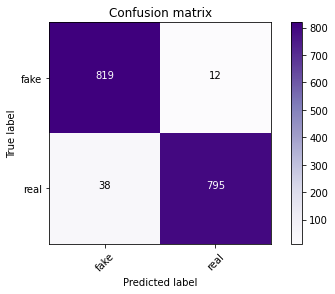

In [26]:
model_nb_one_hot = MultinomialNB(alpha=0.001)
acc, pre, classifier = model_training(model_nb_one_hot, X_train_hstack_one_hot, y_train, x_test_hstack_one_hot, y_test)
joblib.dump(classifier, 'fake_news/model_nb_one_hot')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('naive bayes')
# model_dict['feature_extraction'].append('one hot encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

In [ ]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
} 
model = MultinomialNB()
best_params = hyperparameter_tuning(X_train_hstack_tfidf, y_train, model, parameters, 3, 'multinomial_nb') 

Calculating the parameters for multinomial_nb model

----------------------------------------
best hyperparameters are:- {'alpha': 0.1}

time taken -  0:00:02.775051


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9789663461538461
precision:- 0.9975062344139651


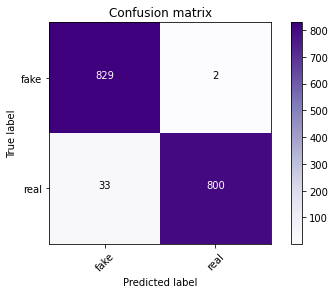

In [27]:
model_nb_tfidf = MultinomialNB(alpha=0.1)
acc, pre, classifier = model_training(model_nb_tfidf, X_train_hstack_tfidf, y_train, x_test_hstack_tfidf, y_test)
joblib.dump(classifier, 'fake_news/model_nb_tfidf')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('naive bayes')
# model_dict['feature_extraction'].append('tfidf encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

<br><br>

# Logistic Regression

In [ ]:
model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.0001, 0.001, 0.01, 0.01, 0.1, 1, 10, 100]
best_params = hyperparameter_tuning(X_train_hstack_one_hot, y_train, model, space, 3, 'logistic_regression') 

Calculating the parameters for logistic_regression model

----------------------------------------
best hyperparameters are:- {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

time taken -  0:15:39.625673


In [ ]:
import warnings
warnings.filterwarnings('ignore')

------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9957932692307693
precision:- 0.9940191387559809


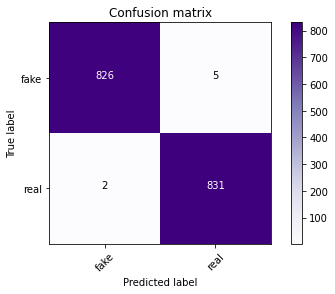

In [28]:
model_lr_one_hot = LogisticRegression(C=100, penalty='l1', solver='liblinear')
acc, pre, classifier = model_training(model_lr_one_hot,  X_train_hstack_one_hot, y_train, x_test_hstack_one_hot, y_test)
joblib.dump(classifier, 'fake_news/model_lr_one_hot')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('logistic regression')
# model_dict['feature_extraction'].append('one hot encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

In [ ]:
model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.0001, 0.01, 0.1, 1, 10, 100]
best_params = hyperparameter_tuning(X_train_hstack_tfidf, y_train, model, space, 3, 'logistic_regression') 

Calculating the parameters for logistic_regression model

----------------------------------------
best hyperparameters are:- {'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}

time taken -  0:04:45.409014


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9951923076923077
precision:- 0.9951980792316927


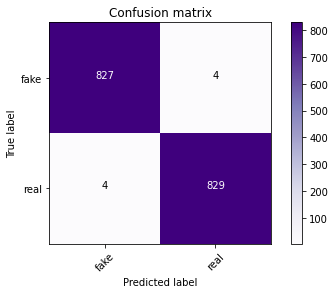

In [29]:
model_lr_tfidf = LogisticRegression(C = 0.0001, penalty = 'none', solver= 'newton-cg')
acc, pre, classifier = model_training(model_lr_tfidf,  X_train_hstack_tfidf, y_train, x_test_hstack_tfidf, y_test)
joblib.dump(classifier, 'fake_news/model_lr_tfidf')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('logistic regression')
# model_dict['feature_extraction'].append('tfidf encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

<br><br>

# SVM

In [26]:
model = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}

best_params = hyperparameter_tuning(X_train_hstack_one_hot, y_train, model, param_grid, 3, 'svc') 

Calculating the parameters for svc model

----------------------------------------
best hyperparameters are:- {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

time taken -  3:22:03.791715


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9861778846153846
precision:- 0.9821428571428571


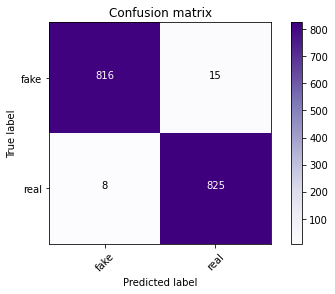

In [30]:
model_svc_one_hot = SVC(C = 0.1, gamma=1, kernel='linear')
acc, pre, classifier = model_training(model_svc_one_hot,  X_train_hstack_one_hot, y_train, x_test_hstack_one_hot, y_test)
joblib.dump(classifier, 'fake_news/model_svc_one_hot')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('svm')
# model_dict['feature_extraction'].append('one hot encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

In [25]:
model = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}

best_params = hyperparameter_tuning(X_train_hstack_tfidf, y_train, model, param_grid, 3, 'svc') 

Calculating the parameters for svc model

----------------------------------------
best hyperparameters are:- {'C': 10, 'gamma': 1, 'kernel': 'linear'}

time taken -  8:58:01.140212


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9951923076923077
precision:- 0.9951980792316927


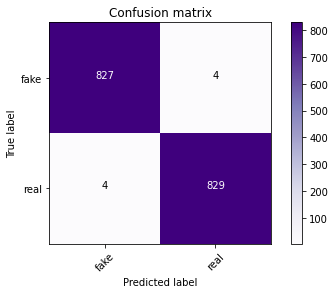

In [26]:
model_svc_tfidf = SVC(C = 10, gamma=1, kernel='linear')
acc, pre, classifier = model_training(model_svc_tfidf,  X_train_hstack_tfidf, y_train, x_test_hstack_tfidf, y_test)
joblib.dump(classifier, 'fake_news/model_svc_tfidf')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('svm')
# model_dict['feature_extraction'].append('tfidf encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

<br><br>

# GradientBoostingclassifier

------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9957932692307693
precision:- 0.9963942307692307


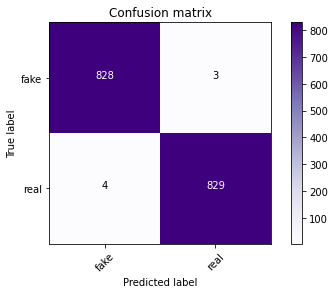

In [26]:
model_gbc_one_hot = GradientBoostingClassifier(n_estimators=1000)
acc, pre, classifier = model_training(model_gbc_one_hot,  X_train_hstack_one_hot, y_train, x_test_hstack_one_hot, y_test)
joblib.dump(classifier, 'fake_news/model_gbc_one_hot')
print('accuracy:-', acc)
print('precision:-', pre)


------------------------fitting the data to classifier------------------------
------------------------predicting the test data------------------------
------------------------plotting the confusion matrix------------------------
Confusion matrix, without normalization
accuracy:- 0.9933894230769231
precision:- 0.9928057553956835


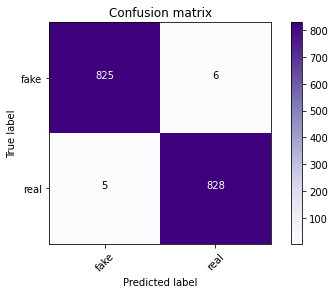

In [27]:
model_gbc_tfidf = GradientBoostingClassifier(n_estimators=1000)
acc, pre, classifier = model_training(model_gbc_tfidf,  X_train_hstack_tfidf, y_train, x_test_hstack_tfidf, y_test)
joblib.dump(classifier, 'fake_news/model_gbc_tfifdf')
print('accuracy:-', acc)
print('precision:-', pre)

# model_dict['model'].append('GradientBoostingclassifier')
# model_dict['feature_extraction'].append('tfidf encoding')
# model_dict['accuracy'].append(acc)
# model_dict['precision'].append(pre)

<br><br>